![](https://images.pexels.com/photos/6618/pexels-photo.jpg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)


# Structure from Motion (SfM)

Kevin J. Walchko, Phd

10 May 2020

---

So the idea here is we want to reconstruct the 3D world from a 2D picture ... how do we do this? First, multi-view, where we take images from different fixed angles and match features between the images. If we know exactly where the camera is (in 3D space), then we can figure out where the rays intersect to the matched points.

![](multi-view.jpg)

![](reconstruct-1.jpg)

Generally, we really don't know 100% where we are and the feature matching algorithm isn't 100% correct, so things go wonky. Below is a great example of robotic's application where the world looks warped, but you still get an idea where things are and could use this information in a variety of robotics applications

![](reconstruct-2.png)

## References

- I don't remember where I originally found this example ... 90% of this is not my work.
- OpenCV docs: [Feature Detection and Description](https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html)
- OpenCV docs: [BRIEF (Binary Robust Independent Elementary Features)](https://docs.opencv.org/3.4/dc/d7d/tutorial_py_brief.html)
- OpenCV docs: [FAST Algorithm for Corner Detection](https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html)
- OpenCV docs: [ORB (Oriented FAST and Rotated BRIEF)](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html)

## A struture from motion example

We will use OpenCV's feature detector on a pair of images to find good features. Scikit-learn’s implementation of PCA is employed to reduce the dimensionality of the descriptors and the KD-Trees in the SciPy library are then used to efficiently find features matches. From the found matches, the fundamental matrix between the pair of images is computed using OpenCV, and linear algebra procedures from SciPy are employed to compute the essential matrix and retrieve valid projection matrices. Finally, SVD decomposition, implemented in scipy.linalg, is used to perform triangulations and estimate a 3D point for each pair of matching features. 

- Take two images input images from a static object
- Compute features and matches between the images
- Recover the fundamental and the essential matrices $\mathrm{\tt F}$ and $\mathrm{\tt E}$
- Extract a pair of projective matrices from $\mathrm{\tt E}$
- Triangulate to get the 3D points $\mathbf{X}_i$

In [1]:
import cv2

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set_style("dark")

In [2]:
from scipy.spatial import cKDTree
from scipy import linalg as la

from sklearn.decomposition import PCA

from random import random

In [66]:
def get_features(p):
    T = cv2.imread(p, cv2.IMREAD_GRAYSCALE).T
    star = cv2.xfeatures2d.StarDetector_create()
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    kp = star.detect(T,None)
    kpts, D = brief.compute(T, kp)
    
    K = np.array([[k.pt[0], k.pt[1]] for k in kpts])
    print(f">> Features: {len(K)}")
    return T, K, D

In [72]:
T1, K1, D_i = get_features('datasets/templeRing/templeR0034.png')
T2, K2, D_j = get_features('datasets/templeRing/templeR0035.png')

>> Features: 299
>> Features: 298


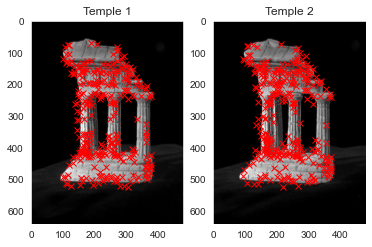

In [73]:
plt.subplot(1,2,1)
plt.plot(K1[:,0], K1[:,1], 'rx')
plt.imshow(T1, cmap=plt.cm.gray)
plt.title('Temple 1')

plt.subplot(1,2,2)
plt.plot(K2[:,0], K2[:,1], 'rx')
plt.imshow(T2, cmap=plt.cm.gray)
plt.title('Temple 2');

## Computing features matches

- Matching
    - $d_i \in \mathbf{D}_i  \rightarrow d_j \in \mathbf{D}_j$
    - Matching is a **nearest neighbor problem**
- In a **low dimensional space**, can be efficiently performed using **KD-Trees**
- However, SIFT descriptors are **128-d** vectors and SURF are **64-d** vectors
- BRIEF can be 128-d, 256-d or 512-d vectors
- Alternatives
    - Approximate Nearest Neighbors (as FLANN library)
    - Brute force matching
    - **Dimensionality reduction**
    
Consider the two sets of descriptors, $\mathbf{D}_i$ and $\mathbf{D}_j$, computed using a feature detector, for two images $I_i$ and $I_j$. Matching can be performed using nearest neighbors, just selecting for each $\mathbf{d}_i \in \mathbf{D}_i$ the closest vector $\mathbf{d}_j \in \mathbf{D}_j$. Nearest neighbor queries can be efficiently done representing $\mathbf{D}_i$ in a KD-Tree. 

KD-Tree performance is close to brute force for vectors presenting large dimensions. Before matching using KD-Trees, a dimensionality reduction procedure, as PCA, is recommended. Sklearn and OpenCV provide PCA implementations. 

In [71]:
pca = PCA(n_components=10)

pca.fit(D_i)
D_i = pca.transform(D_i)
D_j = pca.transform(D_j)

- Lowe recomends to compare the **two nearest neighbors**
- In a **good match**, there is a constrast between the two distances
    - Descriptors with no proper match present similar distances between their closest neighbors
- Filtering
    - $d_j \in \mathbf{D}_j$ should be assigned to just **one** $d_i \in \mathbf{D}_i$

Lowe observes that many features will not have any correct match so just picking the closest neighbor would produce many incorrect matches. The recommended method is to compare the distance of the nearest neighbor to that of the second-closest one. If the ratio between the two distances is below a threshold, the matching is accepted. The rationale behind this procedure is that features with no proper matching would present similar distances between to their closest neighbors.

A KD-Tree is created from the $N_j$ vectors in the array $\mathbf{D}_j$. The `query` procedure takes all vectors in $\mathbf{D}_j$ and the number of closest neighbors to be retrieved, just two in this case ($k=2$). The function return two $N_i \times 2$ arrays, `d` and `nn`, keeping the distances and the neighbors indexes respectively. That means `d[n][0]` keeps the distance between the $n$-th vector in $\mathbf{D}_i$ and its closest neighbor, that is the element `nn[n][0]` in $\mathbf{D}_j$. Fancy indexing is used to select the matches that obey the ratio test proposed by Lowe. Finally, a $N_i \times 2$ array is created, keeping in each row the indexes $n_i$ and $n_j$ such that $n_i$-th descriptor in $\mathbf{D}_i$ matches the $n_j$-th descriptor in $\mathbf{D}_j$. This array `m` is produced using the `vstack`, a function that "stack" arrays vertically, in this case a row of indexes in
$\mathbf{D}_i$ followed by the corresponding matching indexes in $\mathbf{D}_j$.

Other procedure to reject bad matches is to ensure that the same feature $\mathbf{d}_j \in \mathbf{D}_j$ is the proper  match of a single feature $\mathbf{d}_i \in \mathbf{D}_i$.

In the code below, `h` is a Python dictionary acting as an histogram, counting the number of times the $n_j$-th descriptor of $\mathbf{D}_j$ was matched to a descriptor in $\mathbf{D}_i$. The last line just keeps the matches that are unique.

In [54]:
kdtree_j = cKDTree(D_j)
N_i = D_i.shape[0]
d, nn = kdtree_j.query(D_i, k=2)
ratio_mask = d[:,0]/d[:,1] < 0.6
m = np.vstack((np.arange(N_i), nn[:,0])).T
m = m[ratio_mask]

# Filtering: If more than one feature in I matches the same feature in J, 
# we remove all of these matches
h = {nj:0 for nj in m[:,1]}
for nj in m[:,1]:
    h[nj] += 1
        
m = np.array([(ni, nj) for ni, nj in m if h[nj] == 1]) 

In [55]:
def rcolor():
    return (random(), random(), random())

def show_matches(matches):
    
    n_rows, n_cols = T1.shape
    display = np.zeros( (n_rows, 2 * n_cols), dtype=np.uint8 )
    display[:,0:n_cols] = T1
    display[:,n_cols:] = T2

    for pi, pj in matches:
        plt.plot([K1[pi][0], K2[pj][0] + n_cols], 
             [K1[pi][1], K2[pj][1]], 
             marker='o', linestyle='-', color=rcolor())
        
    plt.imshow(display, cmap=plt.cm.gray)
    plt.title(f"Matches Found: {len(matches)}")

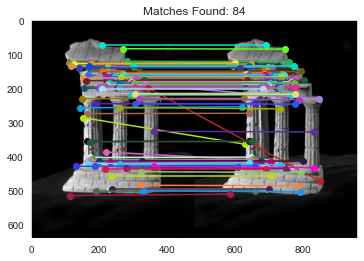

In [56]:
show_matches(m)

## Recovering structure

Find the fundamental matrix $\mathrm{\tt F}$

In [57]:
xi = K1[m[:,0],:]
xj = K2[m[:,1],:]

F, status = cv2.findFundamentalMat(xi, xj, cv2.FM_RANSAC, 0.5, 0.9)

assert(la.det(F) < 1.e-7)
is_inlier = np.array(status == 1).reshape(-1)

inlier_i = xi[is_inlier]
inlier_j = xj[is_inlier]

hg = lambda x : np.array([x[0], x[1], 1])

### Find epipolar matrix $\mathrm{\tt E}$

- The epipolar matrix $\mathrm{\tt E}$ is defined as $\mathrm{\tt E} = \mathrm{\tt K}^\intercal \mathrm{\tt F} \mathrm{\tt K}$, 
- $\mathrm{\tt K}$ is the *calibration matrix* (*camera intrinsics*)
- The values used here are provided by the [Temple Ring dataset](http://vision.middlebury.edu/mview/data/)

In [58]:
K = np.array([[1520.4, 0., 302.32],
           [0, 1525.9, 246.87],
           [0, 0, 1]])

print(f"Camera Matrix(K):\n{K}")

Camera Matrix(K):
[[1.5204e+03 0.0000e+00 3.0232e+02]
 [0.0000e+00 1.5259e+03 2.4687e+02]
 [0.0000e+00 0.0000e+00 1.0000e+00]]


In [59]:
E = np.dot(K.T, np.dot(F, K))
U, s, VT = la.svd(E)

if la.det(np.dot(U, VT)) < 0:
    VT = -VT  
E = np.dot(U, np.dot(np.diag([1,1,0]), VT)) 
V = VT.T
    
# Let's check Nistér (2004) Theorem 3 constraint:
assert(la.det(U) > 0)
assert(la.det(V) > 0)
# Nistér (2004) Theorem 2 ("Essential Condition")
assert sum(np.dot(E, np.dot(E.T, E)) - 0.5 * np.trace(np.dot(E, E.T)) * E)[0] < 1.0e-10

### Direct Linear Transform-based triangulation

Given two corresponding homogeneous points $\mathbf{x}_i$ and $\mathbf{x}_j$, observed in images $I_i$ and $I_j$ respectively, and the projection matrices $\mathrm{\tt P}_i$ and $\mathrm{\tt P}_j$, estimate the 3D points $\mathbf{X}$ in the scene associated to the pair $\mathbf{x}_i \leftrightarrow \mathbf{x}_j$. 

- Rays back-projection
    - Imperfect measures $\mathbf{x}_i$ and $\mathbf{x}_j$ avoids rays intersection
- Alternative
    - Linear least-square formulation
    - Build a system $\mathrm{\tt A}\mathbf{X}$
    - Solve using SVD
    
The point $\mathbf{X}$ could be estimated by rays back-projection in the 3D space. However, in general $\mathbf{x}_i$ and $\mathbf{x}_j$ are imperfect measures and the back-projected rays will not perfectly
intersect in $\mathbf{X}$. Such a problem can be formalized as a linear least-square problem in the system of equations $\mathrm{\tt A}\mathbf{X}$, where $\mathrm{\tt A}$ is defined over $\mathbf{x}_i$, $\mathbf{x}_j$,  $\mathrm{\tt P}_i$ and $\mathrm{\tt P}_j$ (see Section 12.2 of [Hartley and Zisserman's book](http://www.robots.ox.ac.uk/~vgg/hzbook/)). The following code uses the SVD implementation in SciPy to perform the minimization, finding the best estimation of $\mathbf{X}$. Note the last column of $\mathrm{\tt V}$ can be indexed by $-1$.

In [60]:
def dlt_triangulation(ui, Pi, uj, Pj):
    """Hartley & Zisserman, 12.2"""
    ui /= ui[2]
    xi, yi = ui[0], ui[1]
    
    uj /= uj[2]
    xj, yj = uj[0], uj[1]
    
    a0 = xi * Pi[2,:] - Pi[0,:]
    a1 = yi * Pi[2,:] - Pi[1,:]
    a2 = xj * Pj[2,:] - Pj[0,:]
    a3 = yj * Pj[2,:] - Pj[1,:]
    
    A = np.vstack((a0, a1, a2, a3))   
    U, s, VT = la.svd(A)
    V = VT.T    
    
    X3d = V[:,-1]    
       
    return X3d/X3d[3]

### Depth of points

Result 6.1 in [Hartley and Zisserman's book](http://www.robots.ox.ac.uk/~vgg/hzbook/)) says:

> Let $\mathbf{X} = (X, Y, Z, T)^\intercal$ be a 3D point and $\mathrm{\tt P} = [\mathrm{\tt M} | \mathbf{p}_4]$
> be a camera matrix for a finite camera. Suppose $\mathrm{\tt P}(X, Y, Z, T)^\intercal = w(x,y, 1)^\intercal$.
> Then
>
> $\mathrm{depth}(\mathbf{X}, \mathrm{\tt P}) = \frac{\mathrm{sign}(\det \mathrm{\tt M})w}{T\|\mathbf{m}^3\|}$
>
> is the depth of the point $\mathbf{X}$ in front of the principal plane of the camera.

In the result above, $\mathrm{\tt M}$ corresponds to a view on the three first columns of $\mathrm{\tt P}$ and $\mathbf{m}^3$ is the last row of $\mathrm{\tt M}$. The function below takes $\mathbf{X}$ and $\mathrm{\tt P}$ and applies this result to compute the depth of $\mathbf{X}$.

In [61]:
def depth(X, P):
    T = X[3]
    M = P[:,0:3]
    p4 = P[:,3]
    m3 = M[2,:]
    
    x = np.dot(P, X)
    w = x[2]
    X = X/w
    return (np.sign(la.det(M)) * w) / (T*la.norm(m3))

### Getting the projection matrices from $\mathrm{\tt E}$

The code below implements the method described by Nistér (see *[An efficient solution to the five-point relative pose problem](http://dx.doi.org/10.1109/TPAMI.2004.17)*, section 3.1).

In [62]:
def get_proj_matrices(E, K, xi, xj):
    hg = lambda x : np.array([x[0], x[1], 1])
    W = np.array([[0., -1., 0.],
               [1.,  0., 0.],
               [0.,  0., 1.]])

    Pi = np.dot(K, np.hstack( (np.identity(3), np.zeros((3,1))) ))

    U, s, VT = la.svd(E)
    u3 = U[:,2].reshape(3,1)

    # Candidates
    Pa = np.dot(K, np.hstack((np.dot(U, np.dot(W ,VT)), u3)))
    Pb = np.dot(K, np.hstack((np.dot(U, np.dot(W ,VT)), -u3)))
    Pc = np.dot(K, np.hstack((np.dot(U, np.dot(W.T ,VT)), u3)))
    Pd = np.dot(K, np.hstack((np.dot(U, np.dot(W.T ,VT)), -u3)))

    # Find the camera for which the 3D points are *in front*
    xxi, xxj = hg(xi[0]), hg(xj[0])

    Pj = None
    for Pk in [Pa, Pb, Pc, Pd]:
        Q = dlt_triangulation(xxi, Pi, xxj, Pk)    
        if depth(Q, Pi) > 0 and depth(Q, Pk) > 0:
            Pj = Pk
            break

    assert(Pj is not None)
    
    return Pi, Pj

In [63]:
P1, P2 = get_proj_matrices(E, K, inlier_i, inlier_j)

print(f"P1:\n{P1}")
print("")
print(f"P2:\n{P2}")

P1:
[[1.5204e+03 0.0000e+00 3.0232e+02 0.0000e+00]
 [0.0000e+00 1.5259e+03 2.4687e+02 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]]

P2:
[[-1.47742369e+03 -1.32927075e+00 -4.69287784e+02  1.28214368e+03]
 [ 1.97551670e+01 -1.53032082e+03 -2.16895225e+02 -2.69453347e+02]
 [ 1.11008715e-01 -1.90560989e-02 -9.93636719e-01 -3.78212190e-01]]


### Recovering the 3D points using DLT triangulation

In [64]:
X = []
    
for xxi, xxj in zip(inlier_i, inlier_j):
    X_k = dlt_triangulation(hg(xxi), P1, hg(xxj), P2)
    X.append(X_k)
X = np.array(X)

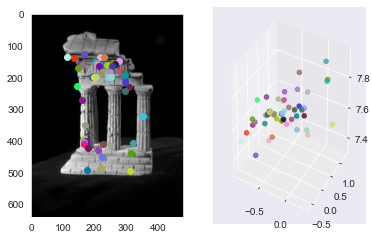

In [65]:
num_pix = X.shape[0]
pix_color = [rcolor() for k in range(num_pix)]

pix = np.dot(P2, X.T).T
pix = np.divide(pix, pix[:,2].reshape(num_pix, -1))

fig = plt.figure()

plt.subplot(1,2,1)
for k in range(num_pix):
    plt.plot(pix[k,0], pix[k,1], color=pix_color[k], marker='o')
plt.imshow(T1, cmap=plt.cm.gray)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], zdir='z', c=pix_color);